In [12]:
from torch_snippets import *
import selectivesearch
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
import zipfile

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:

import zipfile
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('')

In [3]:
df = pd.read_csv('df.csv')
df.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [4]:
class Images(Dataset):
  def __init__(self, df, image_folder='images/images'):
    self.image_folder = image_folder
    self.df = df
    self.unique_images = df['ImageID'].unique()
  def __len__(self):
    return len(self.unique_images)
  def __getitem__(self,idx):
    image_id = self.unique_images[idx]
    image_df = self.df[self.df['ImageID'] == image_id]
    classes = image_df['LabelName'].values.tolist()
    image_path = f'{self.image_folder}/{image_id}.jpg'
    image = cv2.imread(image_path, 1)[...,::-1]
    height, width, _ = image.shape
    bbs = image_df[['XMin', 'YMin', 'XMax', 'YMax']].values
    bbs = np.array([width, height, width, height] * bbs).astype(np.uint16)
    return image, classes, bbs, image_path


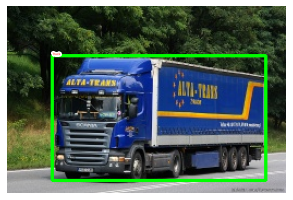

In [7]:
import cv2
ds = Images(df)
test_image, classes, bbs, p = ds[9]

show(test_image,bbs=bbs, texts=classes)

In [8]:
def extract_candidates(img):
  # img - (h,w,3)
  candidates = []
  img_lbl, regions = selectivesearch.selective_search(img, min_size=100, scale=200)
  image_area = np.prod(img.shape[:2])
  for r in regions:
    if r in candidates: 
    if r['size'] < image_area * 0.05: continue
    if r['size'] > image_area * 1: continue
    candidates.append(list(r['rect']))
  return candidates

In [10]:
def extract_iou(boxA, boxB, epsilon = 1e-5):
  x1 = max(boxA[0], boxB[0])
  y1 = max(boxA[1], boxB[1])
  x2 = min(boxA[2], boxB[2])
  y2 = min(boxA[3], boxB[3])
  # Intersection area
  width = x2 - x1
  height = y2 - y1
  intersection_area = width * height
  boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
  boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
  total_area = (boxA_area + boxB_area) - intersection_area
  iou = intersection_area / (total_area + epsilon)
  return iou

In [11]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
N = 500 # Number of images to sample
for ix, (image, classes, bbs, image_path) in enumerate(ds):
  if ix == N: break
  H,W,_ = image.shape
  clss, deltas, rois, ious = [], [], [], []
  candidates = extract_candidates(image)  # Candiadate boxes for images
  candidates = np.array([[x,y,x+w,h+y] for x,y,w,h in candidates])
  # Get IOUS for each candidate (n_candidate, iou to each bbs)
  ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
  for jx, candidate in enumerate(candidates):
    candidate_ious = ious[jx]
    cx,cy,cX,cY = candidate
    best_iou_at = np.argmax(candidate_ious)
    best_iou = candidate_ious[best_iou_at]
    best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
    if best_iou > 0.3:
      clss.append(classes[best_iou_at])
    else:
      clss.append('background')
    delta = np.array([_x - cx, _y - cy, _X - cX, _Y- cY]) / np.array([W,H,W,H])
    roi = np.array([cx,cy,cX,cY]) / np.array([W,H,W,H])
    deltas.append(delta)
    rois.append(roi)
  # Populate arrays
  FPATHS.append(image_path)
  ROIS.append(rois)
  CLSS.append(clss)
  DELTAS.append(deltas)
  IOUS.append(ious)
  GTBBS.append(bbs)

FPATHS = [f'images/images/{stem(image_name)}.jpg' for image_name in FPATHS]

In [13]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

In [17]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
def preprocess_image(img):
  image_tensor = torch.tensor(img).permute(2,0,1)
  image_tensor = normalize(image_tensor)
  return image_tensor.to(device).float()

In [18]:
# validar que hace sto
def decode(_y):
  _, preds = _y.max(-1)
  return preds

In [110]:
class RCNNDataset(Dataset):
  def __init__(self, fpaths,gtbbs,rois,labels,deltas):
    self.fpaths = fpaths
    self.gtbbs = gtbbs
    self.rois = rois
    self.labels = labels
    self.deltas = deltas
  def __len__(self):
    return len(self.fpaths)
  def __getitem__(self, ix):
    fpath = str(self.fpaths[ix])
    image = cv2.imread(fpath, 1)[...,::-1]
    H,W,_ = image.shape
    sh = np.array([W,H,W,H])
    rois = self.rois[ix]
    bbs = (np.array(rois) * sh).astype(np.uint16)
    crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]
    labels = self.labels[ix]
    deltas = self.deltas[ix]
    gtbbs = self.gtbbs[ix]
    return image, crops, bbs, labels, deltas, gtbbs, fpath
  def collate_fn(self, batch):
    crop_size = 244 # TODO: change to 224
    input, rois, labels, deltas = [], [], [], []
    for ix in range(len(batch)):
      image, image_crops, image_bbs, image_labels, image_deltas, image_gtbbs, image_file_path = batch[ix]
      crops = [cv2.resize(crop, (crop_size, crop_size)) for crop in image_crops]
      crops = [preprocess_image(crop/255.)[None] for crop in crops]
      input.extend(crops)
      deltas.extend(image_deltas)
      labels.extend([label2target[l] for l in image_labels])
    input = torch.cat(input).to(device)
    labels = torch.Tensor(labels).long().to(device)
    deltas = torch.Tensor(deltas).float().to(device)
    return input, labels, deltas


In [112]:
n_train = 9 * len(FPATHS) // 10
train_ds = RCNNDataset(FPATHS[:n_train],GTBBS[:n_train],ROIS[:n_train],CLSS[:n_train],DELTAS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:],GTBBS[n_train:],ROIS[n_train:],CLSS[n_train:],DELTAS[n_train:])
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds,batch_size=2,collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds,batch_size=2,collate_fn=test_ds.collate_fn, drop_last=True)

In [21]:
vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
  param.requires_grad = False
vgg_backbone.eval().to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\san191517/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [03:56<00:00, 2.34MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [126]:
import torch.nn as nn

class RCNN(nn.Module):
  def __init__(self):
    super().__init__()
    feature_dim = 25088
    self.backbone = vgg_backbone
    self.cls_score = nn.Linear(feature_dim, len(label2target))
    self.bbox = nn.Sequential(
        nn.Linear(feature_dim, 512),
        nn.ReLU(),
        nn.Linear(512,4),
        nn.Tanh()
    )
    self.cel = nn.CrossEntropyLoss()
    self.sl1 = nn.L1Loss()
  def forward(self, input):
    feat = self.backbone(input)
    cls_score = self.cls_score(feat)
    bbox = self.bbox(feat)
    return cls_score, bbox

  def calc_loss(self, probs, _deltas, labels, deltas):
    detection_loss = self.cel(probs, labels)
    ixs, = torch.where(labels != 0)
    _deltas = _deltas[ixs]
    deltas = deltas[ixs]
    self.lmb = 10.0
    if len(ixs) > 0:
      regression_loss = self.sl1(_deltas, deltas)
      return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
    else:
      regression_loss = 0
      return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()

@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _, _clss = _clss.max(-1)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

def train_batch(inputs, model, optimizer, criterion):
  input,clss,deltas = inputs
  model.train()
  optimizer.zero_grad()
  _clss, _deltas = model(input)
  loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
  accs = clss == decode(_clss)
  loss.backward()
  optimizer.step()
  return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5
log = Report(n_epochs)

In [127]:
for epoch in range(n_epochs):
  _n = len(train_loader)
  for ix, inputs in enumerate(train_loader):
    loss, loc_loss, regr_loss, accs = train_batch(inputs,rcnn,optimizer,criterion)
    pos = (epoch + (ix + 1) /_n)
    log.record(pos, trn_loss=loss.item(),trn_loc_loss=loc_loss, trn_regr_loss=regr_loss, trn_acc=accs.mean(), end='\r')
  _n = len(test_loader)

  for ix, inputs in enumerate(test_loader):
    _clss, _deltas, _loss, loc_loss, regr_loss, accs = validate_batch(inputs,rcnn,criterion)
    pos = (epoch + (ix + 1) /_n)
    log.record(pos, val_loss=loss.item(),val_loc_loss=loc_loss,val_regr_loss=regr_loss,val_acc=accs.mean(),end='\r')

EPOCH: 5.000  val_loss: 0.892  val_loc_loss: 0.448  val_regr_loss: 0.127  val_acc: 0.831  (650.80s - 0.00s remaining)))))

100%|██████████| 106/106 [00:00<00:00, 5594.16it/s]


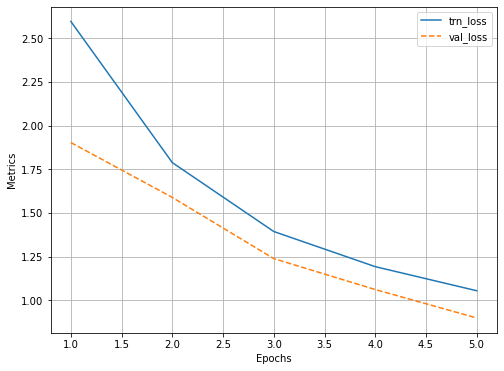

In [128]:
log.plot_epochs('trn_loss,val_loss'.split(','))

In [129]:
def test_predictions(filename, show_output=True):
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    input = torch.cat(input).to(device)
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title(target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1], title='predicted bounding box and class')
    plt.show()
    return (x,y,X,Y),target2label[clss[best_pred]],best_conf

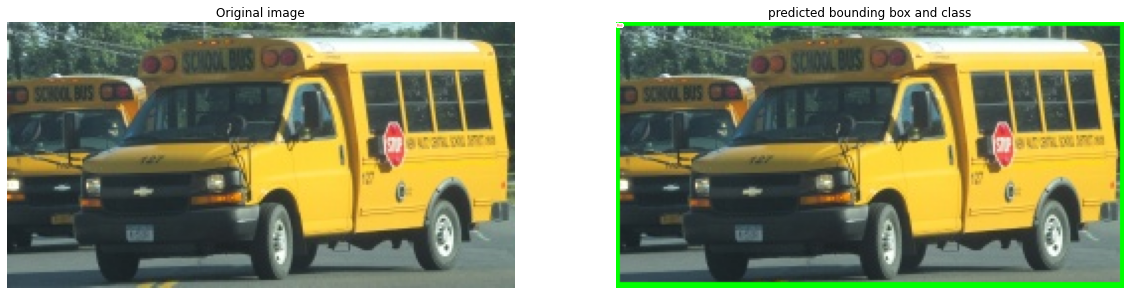

((0, 0, 255, 132), 'Bus', 0.9995117)

In [148]:
image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[24]
test_predictions(fpath)